## Pretraining on unlabeled data

In this chapter training function and pretrain the LLM will be presented. Basic model evaluation techniques will be introduced to measure the quality of the generated text, which is a must for optimizing the LLM during the training process.


###### *note: in the context of LLMs weights refer to the trainable parameters that are learned during the training stage. These weights are known as weight parameters or simply parameters. In PyTorch, these weights can be accessed by us through new_layer.weight or new_layer.parameters().*

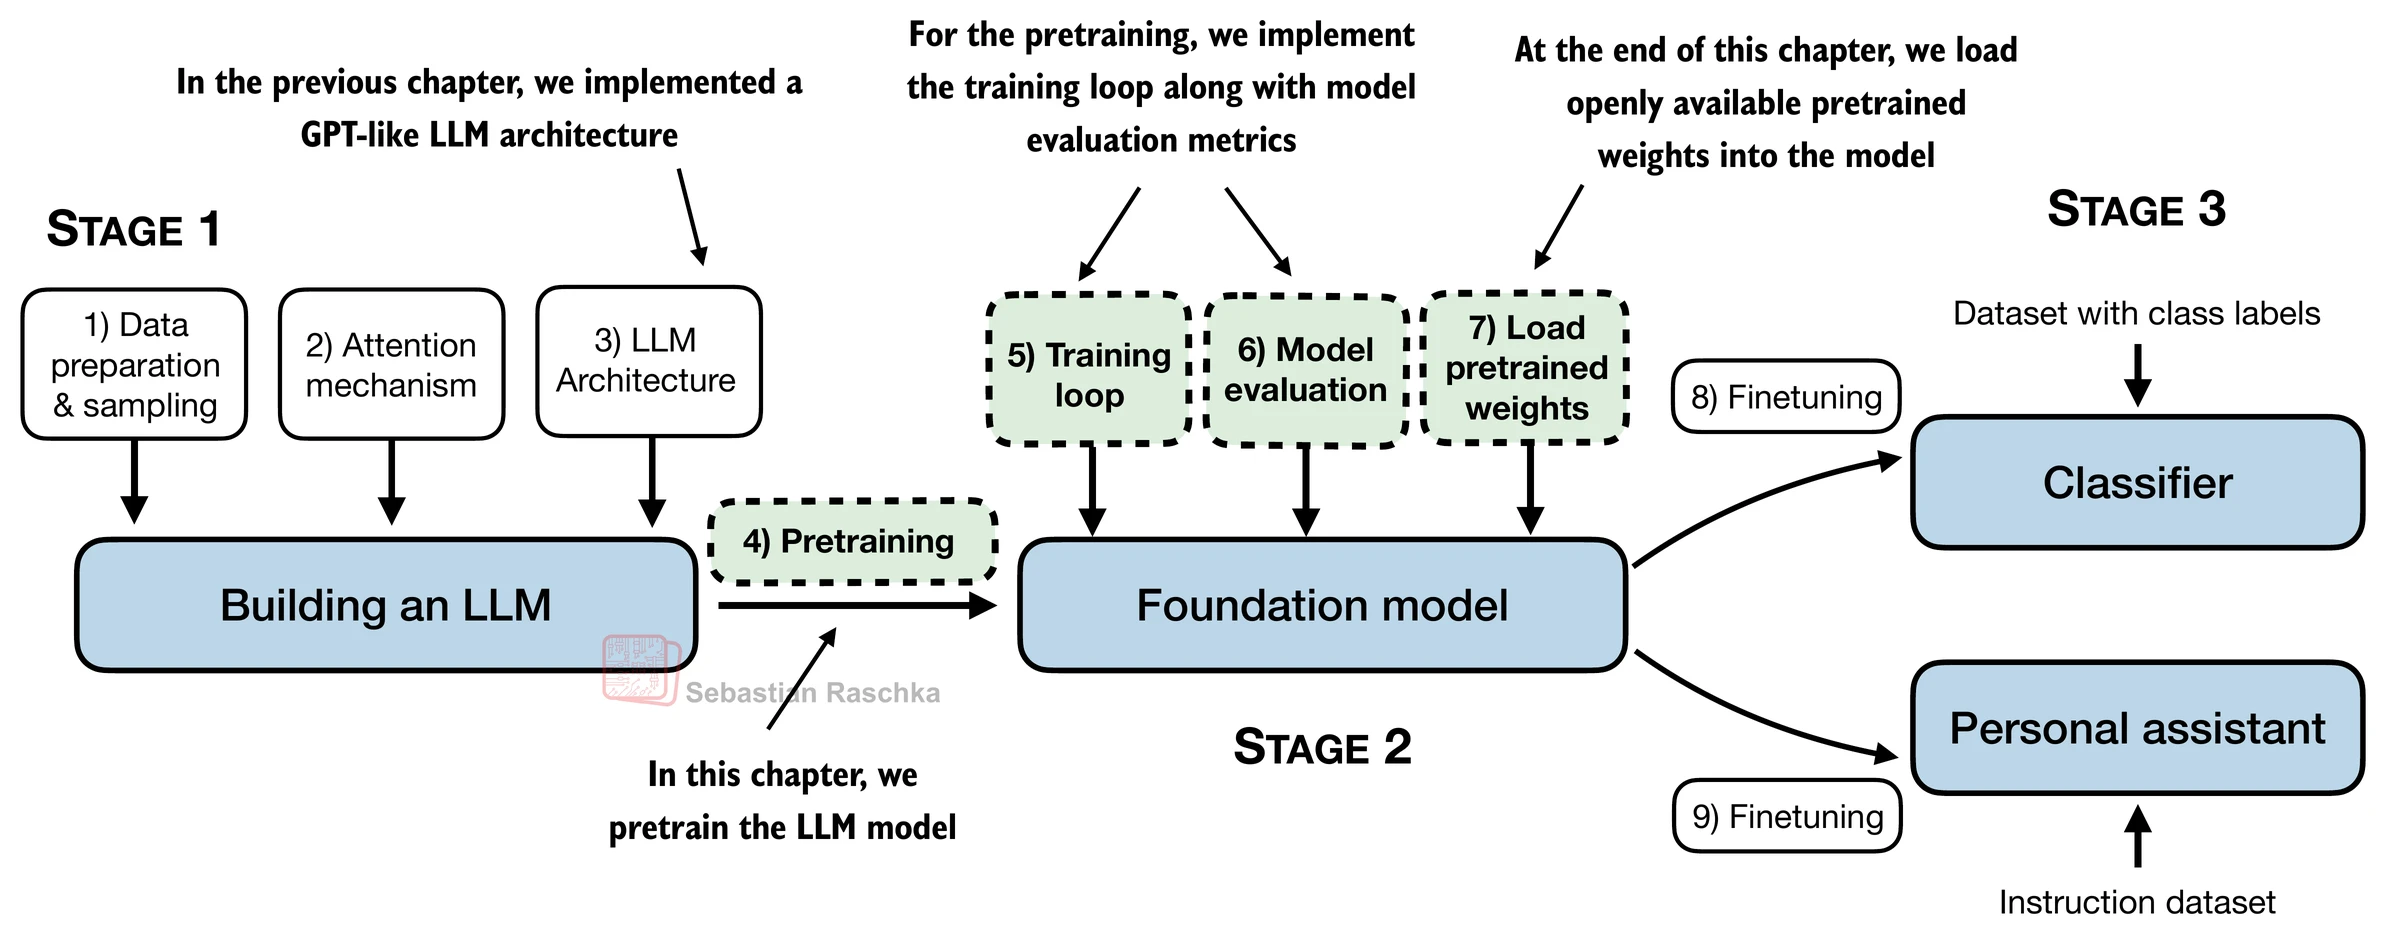

In [1]:
from importlib.metadata import version

pkgs = ["matplotlib", 
        "numpy", 
        "tiktoken", 
        "torch",
        "tensorflow" # For OpenAI's pretrained weights
       ]
for p in pkgs:
    print(f"{p} version: {version(p)}")

matplotlib version: 3.10.7
numpy version: 2.2.6
tiktoken version: 0.12.0
torch version: 2.9.0
tensorflow version: 2.20.0


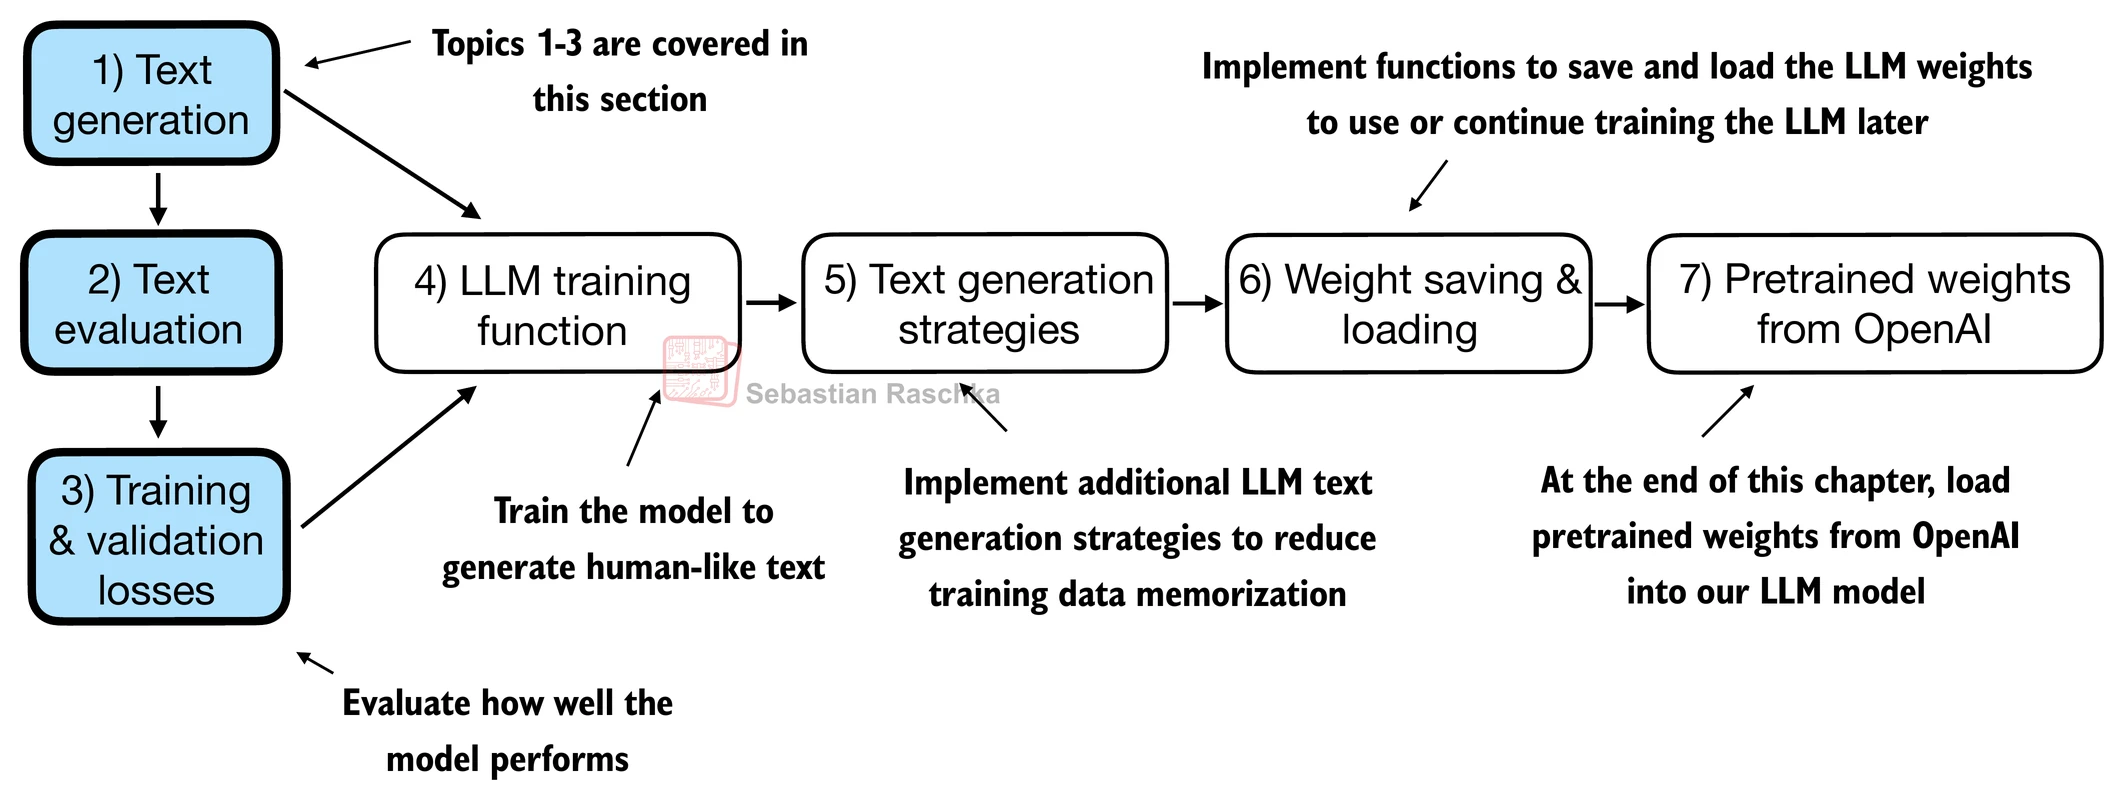

In [9]:
import torch
import sys, os
sys.path.append(os.path.abspath(os.path.join(os.getcwd(), "..")))
from ch04.gpt import GPTModel

GPT_CONFIG_124M = {
    "vocab_size": 50257,   # Vocabulary size
    "context_length": 256, # Shortened context length (orig: 1024) for computational reasons
    "emb_dim": 768,        # Embedding dimension
    "n_heads": 12,         # Number of attention heads
    "n_layers": 12,        # Number of layers
    "drop_rate": 0.1,      # Dropout rate
    "qkv_bias": False      # Query-key-value bias
}

torch.manual_seed(123)
model = GPTModel(GPT_CONFIG_124M)
model.eval();  # Disable dropout during inference

Let's introduce two different functions: text_to_token_ids and token_ids_to_text. These functions facilitate the conversion between text and token representations.

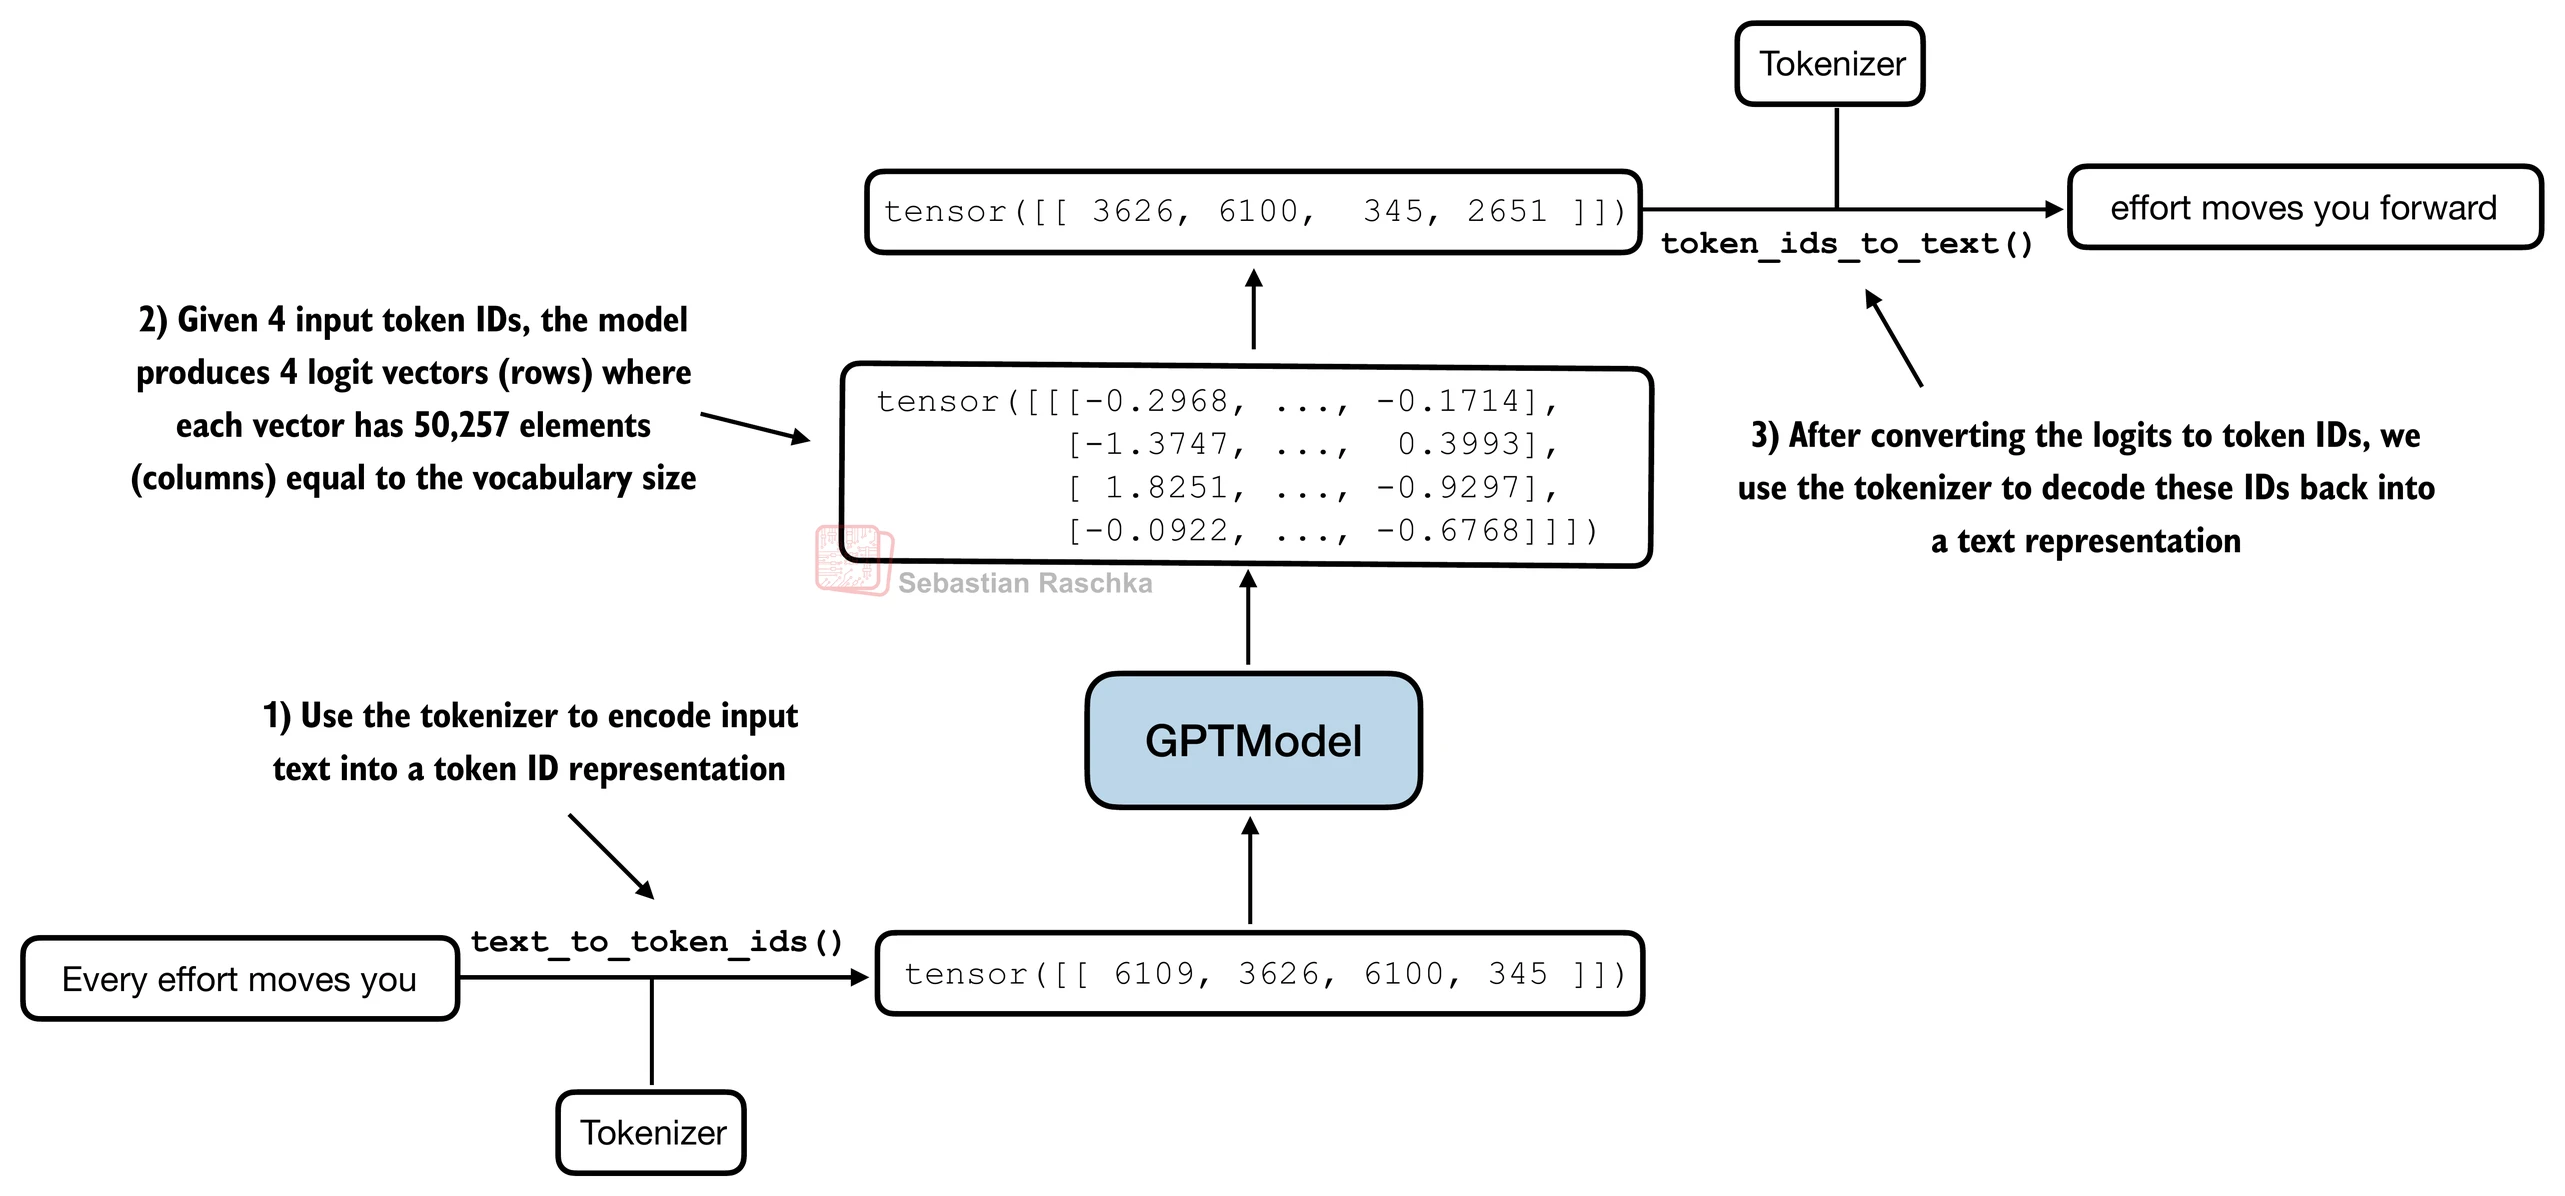

In [ ]:
import tiktoken
import sys, os
sys.path.append(os.path.abspath(os.path.join(os.getcwd(), "..")))
from ch04.gpt import generate_text_simple

def text_to_token_ids(text, tokenizer):
    encoded = tokenizer.encode(text, allowed_special={'<|endoftext|>'})
    encoded_tensor = torch.tensor(encoded).unsqueeze(0) # add batch dimension
    return encoded_tensor

def token_ids_to_text(token_ids, tokenizer):
    flat = token_ids.squeeze(0) # remove batch dimension
    return tokenizer.decode(flat.tolist())

start_context = "Every effort moves you"
tokenizer = tiktoken.get_encoding("gpt2")

token_ids = generate_text_simple(
    model=model,
    idx=text_to_token_ids(start_context, tokenizer),
    max_new_tokens=10,
    context_size=GPT_CONFIG_124M["context_length"]
)

print("Output text:\n", token_ids_to_text(token_ids, tokenizer))

Output text:
 Every effort moves you rentingetic wasnم refres RexMeCHicular stren


Clearly, the model isn't yet producing coherent text because it hasn't undergone training.
To define "coherent", we have to implement a numerical method to evalutate the generated content.
This approach will enables us to monitor and enhance the model's performance throughout its training process.